In [1]:
import numpy as np

def _to_positive_tail(data, tail):
    data = np.asarray(data)
    data = data[np.isfinite(data)]
    if tail == 'right':
        y = data
    elif tail == 'left':
        y = -data
    elif tail in ('abs', 'two-sided', 'magnitude'):
        y = np.abs(data)
    else:
        raise ValueError("tail must be 'right', 'left', or 'abs'")
    y = y[y > 0]
    return y

def _hill_estimator_pos(y, k, min_n=20, tol=1e-12, require_ratio_min=5):
    y = np.asarray(y)
    y = y[np.isfinite(y)]
    y = y[y > 0]
    n = len(y)
    if n < max(min_n, k+1):
        return np.nan, 0 
    y_sorted = np.sort(y)[::-1]
    top_k = y_sorted[:k]
    x_k = y_sorted[k-1]
    ratios = top_k / x_k

    
    ratios = ratios[ratios > 1.0 + tol]
    if len(ratios) < max(require_ratio_min, int(0.5*k)):
        return np.nan, len(ratios)
    alpha = len(ratios) / np.sum(np.log(ratios))
    return float(alpha), int(len(ratios))

def _bootstrap_estimates_pos(y, k, B=500, rng=None, min_n=20, tol=1e-12, require_ratio_min=5):
    rng = np.random.default_rng(rng)
    y = np.asarray(y)
    y = y[np.isfinite(y)]
    y = y[y > 0]
    n = len(y)
    if n < max(min_n, k+1):
        return np.array([])
    ests = []
    for _ in range(B):
        sample = rng.choice(y, size=n, replace=True)
        a, rcount = _hill_estimator_pos(sample, k, min_n=min_n, tol=tol, require_ratio_min=require_ratio_min)
        if np.isfinite(a):
            ests.append(a)
    return np.array(ests)

def _bootstrap_mse_pos(y, k, B=500, rng=None, min_n=20, tol=1e-12, require_ratio_min=5):
    a_hat, _ = _hill_estimator_pos(y, k, min_n=min_n, tol=tol, require_ratio_min=require_ratio_min)
    if not np.isfinite(a_hat):
        return np.inf
    ests = _bootstrap_estimates_pos(y, k, B=B, rng=rng, min_n=min_n, tol=tol, require_ratio_min=require_ratio_min)
    if len(ests) == 0:
        return np.inf
    return float(np.mean((ests - a_hat)**2))



def hill_α_estimator_Bootstrap_mse(
    data, k_min=5, k_max=None, B=1000, ci=0.95, rng=None,
    tail='auto', min_n=20, tol=1e-12, require_ratio_min=5
):
    """
    """
    tails_to_try = ['right', 'left', 'abs'] if tail == 'auto' else [tail]
    rng = np.random.default_rng(rng)

    results = []
    for t in tails_to_try:
        y = _to_positive_tail(data, t)
        n = len(y)
        if n < max(min_n, k_min+1):
            results.append((np.nan, None, np.nan, np.nan, np.inf, t,
                            {'n_pos': n, 'k_range': (None, None), 'ratio_count': 0}))
            continue

        # k-Bereich
        kmax_default = max(6, n // 4) if k_max is None else k_max
        k_min_eff = max(5, k_min)
        k_max_eff = min(kmax_default, n-1)
        if k_min_eff >= k_max_eff:
            results.append((np.nan, None, np.nan, np.nan, np.inf, t,
                            {'n_pos': n, 'k_range': (k_min_eff, k_max_eff), 'ratio_count': 0}))
            continue

        ks = list(range(k_min_eff, k_max_eff+1))
        mses = []
        # sparsamer bootstrap für k-Auswahl
        for k in ks:
            m = _bootstrap_mse_pos(
                y, k, B=min(500, max(100, B//2)), rng=rng,
                min_n=min_n, tol=tol, require_ratio_min=require_ratio_min
            )
            mses.append(m)

        
        k_opt = ks[int(np.argmin(mses))]
        mse_opt = mses[int(np.argmin(mses))]

        
        alpha_hat, ratio_count = _hill_estimator_pos(
            y, k_opt, min_n=min_n, tol=tol, require_ratio_min=require_ratio_min
        )
        ests = _bootstrap_estimates_pos(
            y, k_opt, B=B, rng=rng, min_n=min_n, tol=tol, require_ratio_min=require_ratio_min
        )
        if len(ests) >= 50:
            lo = float(np.quantile(ests, (1-ci)/2))
            hi = float(np.quantile(ests, 1-(1-ci)/2))
        else:
            lo, hi = np.nan, np.nan

        results.append((
            float(alpha_hat) if np.isfinite(alpha_hat) else np.nan,
            int(k_opt) if k_opt is not None else None,
            lo, hi,
            float(mse_opt) if np.isfinite(mse_opt) else np.inf,
            t,
            {'n_pos': n, 'k_range': (k_min_eff, k_max_eff), 'ratio_count': int(ratio_count)}
        ))

    valid = [r for r in results if np.isfinite(r[4]) and not np.isnan(r[0])]
    if not valid:
        best_idx = int(np.argmax([r[6]['n_pos'] for r in results])) if results else 0
        r = results[best_idx]
        return np.nan, None, np.nan, np.nan, np.inf, None, {'tried': results}
        
    mse_vals = [r[4] for r in valid]
    best_mse = np.min(mse_vals)
    candidates = [r for r in valid if np.isclose(r[4], best_mse)]
    if len(candidates) > 1:
        best_idx = int(np.argmax([r[6]['n_pos'] for r in candidates]))
        best = candidates[best_idx]
    else:
        best = candidates[0]

    alpha_hat, k_opt, lo, hi, mse, chosen_tail, diag = best
    diag_all = {'chosen': diag, 'tried': results}
    return alpha_hat, k_opt, lo, hi, mse, chosen_tail, diag_all



TypeError: hill_α_estimator_Bootstrap_mse() got an unexpected keyword argument 'seed'

(7.147151338949981, 21, 5.1186936431931205, 11.756649962914395, 2.2918452769199456, 'abs', {'chosen': {'n_pos': 90, 'k_range': (5, 22), 'ratio_count': 20}, 'tried': [(nan, None, nan, nan, inf, 'right', {'n_pos': 9, 'k_range': (None, None), 'ratio_count': 0}), (6.901821020777918, 20, 5.178622897180245, 12.491656867351866, 3.9271256711619014, 'left', {'n_pos': 81, 'k_range': (5, 20), 'ratio_count': 19}), (7.147151338949981, 21, 5.1186936431931205, 11.756649962914395, 2.2918452769199456, 'abs', {'n_pos': 90, 'k_range': (5, 22), 'ratio_count': 20})]})


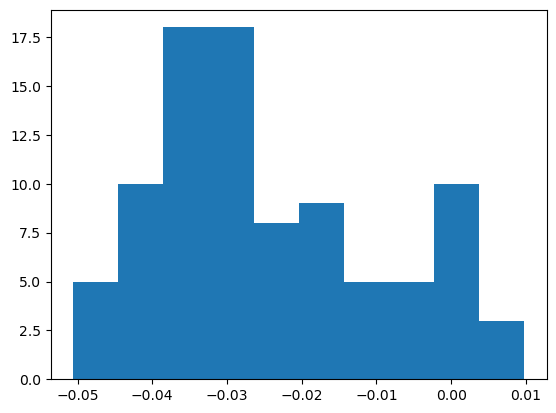

In [33]:
data = [-7.63705853e-03 -1.81231177e-02 -2.51581766e-02 -1.88588296e-02
 -2.67759119e-02 -3.35593033e-02 -3.92479908e-02 -3.39389470e-02
 -2.91246395e-02 -2.84639097e-02 -2.55715119e-02 -5.72302117e-03
 -9.27901755e-04  1.56363399e-03  9.77058887e-03  4.15123276e-03
  3.64744175e-03  7.57832020e-03  2.35214110e-03  9.19922515e-04
 -6.01309273e-03 -5.17277380e-03 -1.31257151e-02 -3.57826417e-05
  3.15484613e-03 -1.99518751e-04  2.83752929e-03 -8.66004859e-03
 -1.32949296e-02 -1.64343418e-02 -1.45829801e-02 -1.85355435e-02
 -3.25718031e-02 -3.66956610e-02 -3.04904867e-02 -3.58939423e-02
 -3.58125178e-02 -3.50620173e-02 -3.34426766e-02 -3.43455061e-02
 -3.45517703e-02 -3.20528352e-02 -2.84179557e-02 -1.93298817e-02
 -2.41780954e-02 -2.51878571e-02 -2.01755639e-02 -1.87406758e-02
 -1.66438804e-02 -2.64427556e-02 -2.44229022e-02 -2.83764030e-02
 -4.09743688e-02 -3.10364475e-02 -2.24062876e-02 -3.27294779e-02
 -3.93182712e-02 -3.31851136e-02 -4.27741322e-02 -4.98704307e-02
 -4.83623505e-02 -4.58048036e-02 -4.61517926e-02 -3.90814879e-02
 -2.68825379e-02 -3.09230965e-02 -3.88971825e-02 -3.53393302e-02
 -3.83555196e-02 -3.69982332e-02 -3.43850137e-02 -4.16659177e-02
 -3.01066298e-02 -2.83900751e-02 -3.09553427e-02 -3.91219895e-02
 -5.05690748e-02 -4.21726039e-02 -3.06453410e-02 -2.69555325e-02
 -2.70754185e-02 -3.60800016e-02 -3.43049140e-02 -2.24727788e-02
 -2.80269959e-02 -4.02270115e-02 -2.25457795e-02 -1.00216492e-02
 -7.50105995e-03 -1.04852482e-02  0.00000000e+00]

plt.hist(data)

print(hill_α_estimator_Bootstrap_mse(data))